<a href="https://colab.research.google.com/github/itberrios/CV_projects/blob/main/RAFT/RAFT_deep_dive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RAFT Deep Dive**

## NOTE: GPU is required for this tutorial

In [1]:
!git clone https://github.com/princeton-vl/RAFT.git

Cloning into 'RAFT'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 147 (delta 0), reused 1 (delta 0), pack-reused 144
Receiving objects: 100% (147/147), 10.01 MiB | 31.55 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [2]:
import os
import sys
import numpy as np
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# add RAFT to core path
sys.path.append('RAFT/core')

In [4]:
# download models
%cd RAFT
!./download_models.sh
%cd ..

/content/RAFT
--2023-09-07 01:27:27--  https://dl.dropboxusercontent.com/s/4j4z58wuv8o0mfz/models.zip
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.3.15, 2620:100:6018:15::a27d:30f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.3.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81977417 (78M) [application/zip]
Saving to: ‘models.zip’

models.zip          100%[===================>]  78.18M   117MB/s    in 0.7s    

2023-09-07 01:27:29 (117 MB/s) - ‘models.zip’ saved [81977417/81977417]

Archive:  models.zip
   creating: models/
  inflating: models/raft-kitti.pth   
  inflating: models/raft-sintel.pth  
  inflating: models/raft-chairs.pth  
  inflating: models/raft-things.pth  
  inflating: models/raft-small.pth   
/content


### Helper Functions

In [5]:
from collections import OrderedDict
from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder



def process_img(img, device):
    return torch.from_numpy(img).permute(2, 0, 1).float()[None].to(device)


def load_model(weights_path, args):
    model = RAFT(args)
    pretrained_weights = torch.load(weights_path, map_location=torch.device("cpu"))
    model = torch.nn.DataParallel(model)
    model.load_state_dict(pretrained_weights)
    model.to("cuda")
    return model


def inference(model, frame1, frame2, device, pad_mode='sintel',
              iters=12, flow_init=None, upsample=True, test_mode=True):

    model.eval()
    with torch.no_grad():
        # preprocess
        frame1 = process_img(frame1, device)
        frame2 = process_img(frame2, device)

        padder = InputPadder(frame1.shape, mode=pad_mode)
        frame1, frame2 = padder.pad(frame1, frame2)

        # predict flow
        if test_mode:
          flow_low, flow_up = model(frame1,
                                    frame2,
                                    iters=iters,
                                    flow_init=flow_init,
                                    upsample=upsample,
                                    test_mode=test_mode)



          return flow_low, flow_up

        else:
            flow_iters = model(frame1,
                               frame2,
                               iters=iters,
                               flow_init=flow_init,
                               upsample=upsample,
                               test_mode=test_mode)

            return flow_iters


def get_viz(flo):
    flo = flo[0].permute(1,2,0).cpu().numpy()
    return flow_viz.flow_to_image(flo)

# sketchy class to pass to RAFT
class Args():
  def __init__(self, model='', path='', small=False, mixed_precision=True, alternate_corr=False):
    self.model = model
    self.path = path
    self.small = small
    self.mixed_precision = mixed_precision
    self.alternate_corr = alternate_corr

  """ Sketchy hack to pretend to iterate through the class objects """
  def __iter__(self):
    return self

  def __next__(self):
    raise StopIteration

### Test Run RAFT

In [11]:
demo_path = 'RAFT/demo-frames'
frame1 = cv2.imread(os.path.join(demo_path, 'frame_0020.png'))
frame2 = cv2.imread(os.path.join(demo_path, 'frame_0021.png'))

frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

In [7]:
# load model
model = load_model("RAFT/models/raft-sintel.pth", args=Args())

# predict Optical Flow
flow_iters = inference(model, frame1, frame2, device='cuda', test_mode=False)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


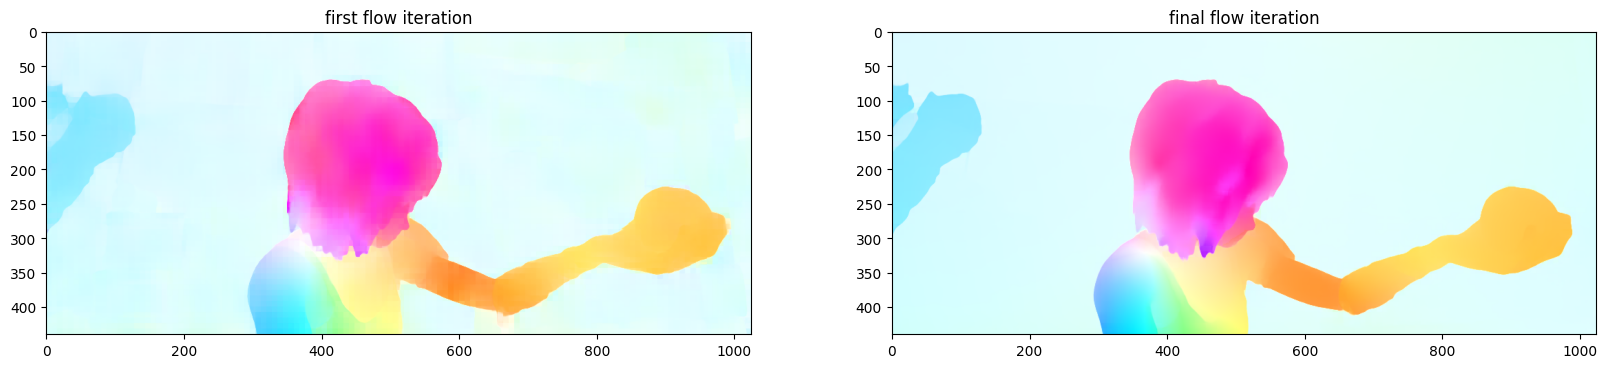

In [8]:
_, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(get_viz(flow_iters[0]))
ax0.set_title('first flow iteration')
ax1.imshow(get_viz(flow_iters[-1]))
ax1.set_title('final flow iteration');

# **Explore Different Blocks of RAFT**

First preprocess the data

In [64]:
demo_path = 'RAFT/demo-frames'
frame1 = cv2.imread(os.path.join(demo_path, 'frame_0020.png'))
frame2 = cv2.imread(os.path.join(demo_path, 'frame_0021.png'))

frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)


# neural net processing
frame1 = process_img(frame1, device='cuda')
frame2 = process_img(frame2, device='cuda')

padder = InputPadder(frame1.shape, mode='sintel')
frame1, frame2 = padder.pad(frame1, frame2)

frame1 = 2 * (frame1 / 255.0) - 1.0
frame2 = 2 * (frame2 / 255.0) - 1.0

frame1 = frame1.contiguous()
frame2 = frame2.contiguous()

## **Explore the Correlation Block**

In [86]:
from corr import CorrBlock

# compute feature maps
with torch.autocast(device_type='cuda', enabled=True):
    fmap1, fmap2 = model.module.fnet([frame1, frame2])

fmap1 = fmap1.float()
fmap2 = fmap2.float()

# compute correlation pyramid
corr_fn = CorrBlock(fmap1, fmap2, num_levels=4, radius=4)

In [87]:
# check sizes of correlation pyramid
print(frame1.shape)
for i in range(4):
  print(corr_fn.corr_pyramid[i].shape)

torch.Size([1, 3, 440, 1024])
torch.Size([7040, 1, 55, 128])
torch.Size([7040, 1, 27, 64])
torch.Size([7040, 1, 13, 32])
torch.Size([7040, 1, 6, 16])


Initialize the flow

In [88]:
# returns a mesh grid tensor at 1/8 the sizee of the input frame
coords0, coords1 = model.module.initialize_flow(frame1)

### Explore Correlation Look Up Operator
#### Go through code to index correlation volume

In [89]:
r = 4 # radius
coords = coords1.detach().permute(0, 2, 3, 1)
batch, h1, w1, _ = coords.shape
out_pyramid = []

In [148]:
i = 0
_corr = corr_fn.corr_pyramid[i]
dx = torch.linspace(-r, r, 2*r+1, device=coords.device)
dy = torch.linspace(-r, r, 2*r+1, device=coords.device)
delta = torch.stack(torch.meshgrid(dy, dx), axis=-1)

In [149]:
dx, dy, delta.shape

(tensor([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.], device='cuda:0'),
 tensor([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.], device='cuda:0'),
 torch.Size([9, 9, 2]))

In [150]:
centroid_lvl = coords.reshape(batch*h1*w1, 1, 1, 2) / 2**i
delta_lvl = delta.view(1, 2*r+1, 2*r+1, 2)
coords_lvl = centroid_lvl + delta_lvl

In [151]:
centroid_lvl.shape, delta_lvl.shape, coords_lvl.shape

(torch.Size([7040, 1, 1, 2]),
 torch.Size([1, 9, 9, 2]),
 torch.Size([7040, 9, 9, 2]))

In [152]:
_corr.shape

torch.Size([7040, 1, 55, 128])

Sample the

In [153]:
from RAFT.core.utils.utils import bilinear_sampler

corr = bilinear_sampler(_corr, coords_lvl)

In [154]:
corr.shape, _corr.shape, coords_lvl.shape

(torch.Size([7040, 1, 9, 9]),
 torch.Size([7040, 1, 55, 128]),
 torch.Size([7040, 9, 9, 2]))

In [155]:
corr[0, 0, :, :].round()

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 11.,  3.,  1.,  4.,  4.],
        [ 0.,  0.,  0.,  0.,  3.,  1., -1., -1.,  1.],
        [ 0.,  0.,  0., -0., -1., -1., -1., -1., -1.],
        [ 0.,  0.,  0.,  0.,  1., -1.,  2.,  4.,  1.],
        [ 0.,  0.,  0.,  0.,  6.,  0.,  1.,  1.,  1.]], device='cuda:0',
       grad_fn=<RoundBackward0>)

In [163]:
_corr[0, 0, :, :].round()

tensor([[11.,  3., -1.,  ...,  0.,  0.,  2.],
        [ 3.,  1., -1.,  ...,  1.,  0.,  2.],
        [ 1., -1., -1.,  ...,  1., -0.,  1.],
        ...,
        [-3., -1.,  1.,  ..., -1.,  2.,  1.],
        [-2., -1.,  3.,  ..., -2., -0., -0.],
        [-2., -1., -1.,  ..., -0., -0.,  1.]], device='cuda:0',
       grad_fn=<RoundBackward0>)

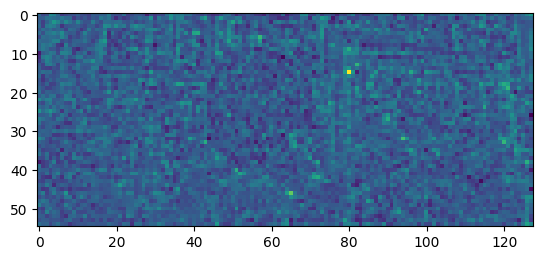

In [176]:
plt.imshow(_corr[2000, 0, :, :].detach().cpu().numpy());

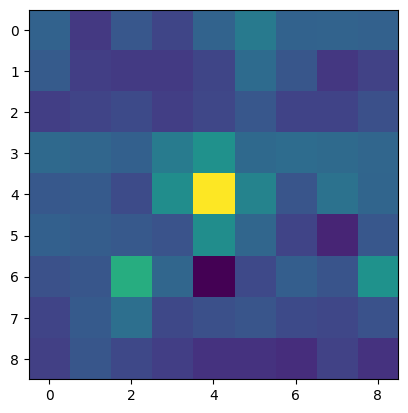

In [177]:
plt.imshow(corr[2000, 0, :, :].detach().cpu().numpy());

In [179]:
_corr[2000, 0, :, :].max(), corr[2000, 0, :, :].max()

(tensor(7.8238, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(7.8238, device='cuda:0', grad_fn=<MaxBackward1>))

In [162]:
coords_lvl[0, :, :, 1].round()

tensor([[-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.],
        [-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.],
        [-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.],
        [-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.],
        [-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.],
        [-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.],
        [-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.],
        [-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.],
        [-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]], device='cuda:0')

In [158]:
corr.view(batch, h1, w1, -1).shape

torch.Size([1, 55, 128, 81])

In [160]:
corr.view(batch, h1, w1, -1)[0, 0, 0, :].round()

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 11.,  3.,
         1.,  4.,  4.,  0.,  0.,  0.,  0.,  3.,  1., -1., -1.,  1.,  0.,  0.,
         0., -0., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,  1., -1.,  2.,
         4.,  1.,  0.,  0.,  0.,  0.,  6.,  0.,  1.,  1.,  1.],
       device='cuda:0', grad_fn=<RoundBackward0>)

In [124]:
# index the correlation volume
tmp = coords1.detach()
temp2 = corr_fn(tmp)

In [126]:
tmp.shape, temp2.shape

(torch.Size([1, 2, 55, 128]), torch.Size([1, 324, 55, 128]))

In [127]:
7040*4, 1*4, 9*4, 9*4

(28160, 4, 36, 36)